# Load

In [17]:
import kerastuner as kt
import tensorflow as tf
import pandas as pd

data = pd.read_csv("telematics_syn-032021.csv")
cat_cols = data.select_dtypes("object").columns
data[cat_cols] = data[cat_cols].astype("category")
data = data[data['NB_Claim'] >= 1]
data.describe()

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Territory,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
count,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,...,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000,4272.000000
mean,345.482444,46.825609,4.503511,769.774813,9913.616493,23.777856,56.573736,0.745872,8738.822176,0.140284,...,1328.832163,1219.390449,1167.944991,1365.415496,1053.774579,794.040964,679.961845,541.848315,1.051966,3221.026524
std,53.725249,14.520068,3.641508,91.177558,4006.128767,15.016561,23.249971,0.250546,5443.475664,0.024375,...,19399.614119,19104.954515,18896.874180,14973.739947,14867.604195,14515.613752,13733.581643,11996.308065,0.233299,5243.325559
min,181.000000,18.000000,-2.000000,428.000000,683.508100,0.000000,12.000000,0.035616,67.224394,0.014633,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,365.000000,35.000000,1.000000,715.000000,6213.710000,10.000000,35.000000,0.528767,4781.810981,0.125720,...,2.000000,1.000000,0.000000,50.000000,17.000000,3.000000,1.000000,0.000000,1.000000,530.191910
50%,366.000000,47.000000,4.000000,792.000000,9320.565000,23.000000,63.000000,0.835616,7772.176235,0.139538,...,13.000000,4.000000,1.000000,329.000000,145.000000,34.000000,11.000000,4.000000,1.000000,1718.502594
75%,366.000000,57.000000,7.000000,838.000000,12427.420000,35.000000,76.000000,0.972603,11364.850417,0.152976,...,66.000000,25.000000,9.000000,1027.000000,543.000000,171.000000,73.000000,28.000000,1.000000,3783.871033
max,366.000000,90.000000,18.000000,900.000000,33802.582400,74.000000,91.000000,1.000000,41019.575278,0.313402,...,452486.000000,447805.000000,441232.000000,380712.000000,378190.000000,368195.000000,363010.000000,360016.000000,3.000000,104074.886700


# Inspect

(array([3.557e+03, 4.710e+02, 1.250e+02, 4.900e+01, 2.600e+01, 1.400e+01,
        1.200e+01, 6.000e+00, 5.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([     0.      ,   5203.744335,  10407.48867 ,  15611.233005,
         20814.97734 ,  26018.721675,  31222.46601 ,  36426.210345,
         41629.95468 ,  46833.699015,  52037.44335 ,  57241.187685,
         62444.93202 ,  67648.676355,  72852.42069 ,  78056.165025,
         83259.90936 ,  88463.653695,  93667.39803 ,  98871.142365,
        104074.8867  ]),
 <BarContainer object of 20 artists>)

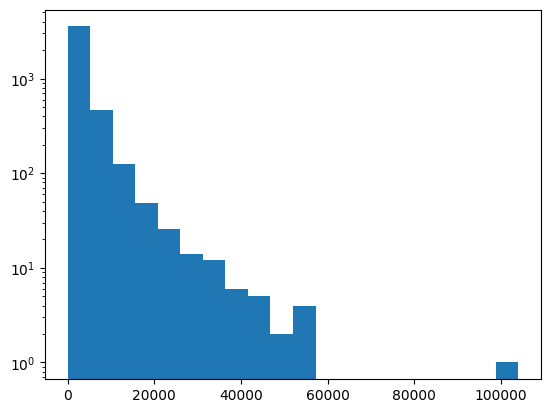

In [28]:
import matplotlib.pyplot as plt

response = 'AMT_Claim'
plt.yscale('log')
plt.hist(data[response], bins=20)

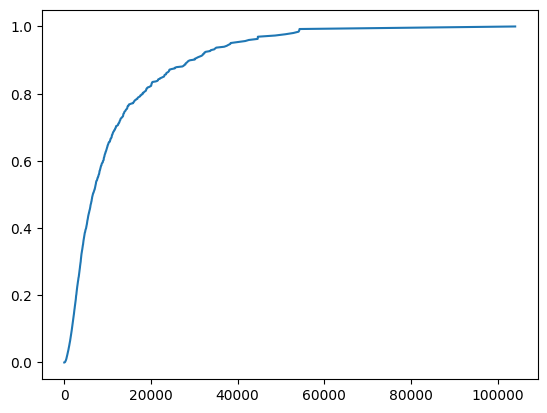

In [51]:
ordered_response = data[response].sort_values(ascending=True)
plt.plot(ordered_response, ordered_response.cumsum()/ordered_response.cumsum().iloc[-1])

Text(0.5, 1.0, 'Lorenz Curve - Gini coefficient 0.62')

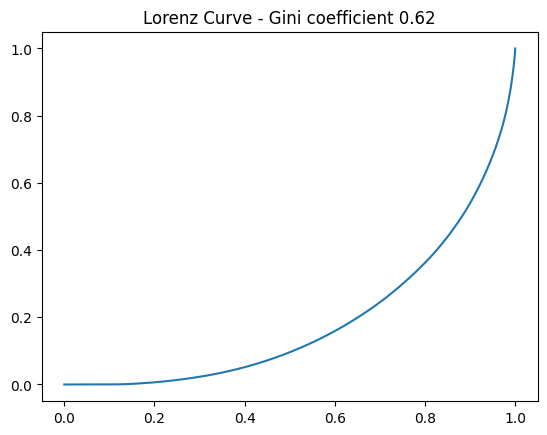

In [25]:
import numpy as np
ordered_response = data[response].sort_values(ascending=True)
cum_sum  = ordered_response.cumsum()
cum_sum  /= cum_sum.iloc[-1]
percentile = np.linspace(0,1,len(cum_sum))
plt.plot(percentile, cum_sum)
plt.title(f"Lorenz Curve - Gini coefficient {1-np.trapz(cum_sum, percentile)*2:.2f}")

# Tensorflow dataset

In [36]:
from sklearn.model_selection import train_test_split
train_og, val_og = train_test_split(data, test_size=0.4)
val_og, test_og = train_test_split(val_og, test_size=0.5)

covariates = [x for x in data.columns if x != response]
train, val, test = train_og.copy(), val_og.copy(), test_og.copy()

# Target encode categories
for cat_col in train.select_dtypes("category").columns:
    encodings = train[[response, cat_col]].groupby(cat_col).mean()
    train[cat_col] = train[cat_col].map(encodings.iloc[:,0])
    val[cat_col] = val[cat_col].map(encodings.iloc[:,0])
    test[cat_col] = test[cat_col].map(encodings.iloc[:,0])

train_ds = tf.data.Dataset.from_tensor_slices((train[covariates], train[response])).batch(64).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((val[covariates], val[response])).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test[covariates], test[response])).batch(64)

# MLP Training

In [44]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

def build_model(hp: kt.HyperParameters):
    d_model = hp.Int('d_model', min_value=16, max_value=128)
    activation = hp.Choice('activation', ['relu', 'selu', 'sigmoid'])
    _in = Input((len(covariates,)))
    x1 = Dense(d_model, activation=activation)(_in)
    x2 = Dense(d_model, activation=activation)(x1) 
    model = Model(_in, Dense(1)(x1+x2))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [45]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss'
)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [46]:
tuner.search(
    train_ds, 
    validation_data=val_ds, 
    epochs=100
)

Trial 236 Complete [00h 00m 12s]
val_loss: 24888300.0

Best val_loss So Far: 24179228.0
Total elapsed time: 21h 06m 29s
INFO:tensorflow:Oracle triggered exit


In [48]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
d_model: 66
activation: relu
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 24179228.0
Trial summary
Hyperparameters:
d_model: 34
activation: selu
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 24262586.0
Trial summary
Hyperparameters:
d_model: 82
activation: relu
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0221
Score: 24330334.0
Trial summary
Hyperparameters:
d_model: 43
activation: relu
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0222
Score: 24335080.0
Trial summary
Hyperparameters:
d_model: 82
activation: relu
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 24364356.0
Trial summary
Hyperparameters:
d_model: 125
activation: relu
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0

# Catboost?

In [53]:
import catboost

In [67]:
best_model = None
accs = {}
best_acc = 0

cats = train.select_dtypes("category")

alt_train = train.copy()
alt_train[cats.columns] = cats.astype(str)
alt_val = val.copy()
alt_val[cats.columns] = alt_val.select_dtypes("category").astype(str)

for partition in [100, 500, 1000, 2000, 4000, 5000, 10000, 20000]:
    partitioning_model = catboost.CatBoostClassifier()

    partitioning_model.fit(
        alt_train[covariates], (alt_train[response] > partition).astype(int),
        eval_set=(alt_val[covariates], (alt_val[response] > partition).astype(int))
    )
    val_perf = partitioning_model.predict(alt_val[covariates])
    acc = (val_perf ==  (alt_val[response] > partition).astype(int)).astype(int).sum()/len(alt_val)
    accs[partition] = acc
    print(partition, acc)
    if acc > best_acc:
        best_model = (partitioning_model, partition)
        best_acc = acc


Learning rate set to 0.039983
0:	learn: 0.6591991	test: 0.6592684	best: 0.6592684 (0)	total: 5.41ms	remaining: 5.4s
1:	learn: 0.6278884	test: 0.6278827	best: 0.6278827 (1)	total: 10.6ms	remaining: 5.3s
2:	learn: 0.6024539	test: 0.6021845	best: 0.6021845 (2)	total: 14.9ms	remaining: 4.94s
3:	learn: 0.5774562	test: 0.5774270	best: 0.5774270 (3)	total: 19.3ms	remaining: 4.8s
4:	learn: 0.5543409	test: 0.5543365	best: 0.5543365 (4)	total: 24ms	remaining: 4.78s
5:	learn: 0.5346473	test: 0.5346403	best: 0.5346403 (5)	total: 27.8ms	remaining: 4.6s
6:	learn: 0.5153225	test: 0.5148662	best: 0.5148662 (6)	total: 32.9ms	remaining: 4.67s
7:	learn: 0.4993461	test: 0.4989089	best: 0.4989089 (7)	total: 37.7ms	remaining: 4.67s
8:	learn: 0.4832060	test: 0.4828472	best: 0.4828472 (8)	total: 41.5ms	remaining: 4.57s
9:	learn: 0.4688858	test: 0.4686388	best: 0.4686388 (9)	total: 45.7ms	remaining: 4.52s
10:	learn: 0.4576905	test: 0.4572911	best: 0.4572911 (10)	total: 51.2ms	remaining: 4.6s
11:	learn: 0.44733

In [68]:
best_model, best_acc

((<catboost.core.CatBoostClassifier at 0x7fa89c5df160>, 20000),
 0.9812646370023419)